In [71]:
from datasets import *

from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.algorithms.classical.svm.svm_classical import SVM_Classical
from qiskit.aqua.components.feature_maps import SecondOrderExpansion, FirstOrderExpansion, PauliZExpansion, PauliExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiement on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_accounts()` to store it first.

In [2]:
from qiskit import IBMQ
IBMQ.load_accounts()

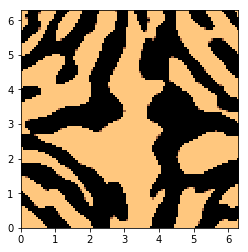

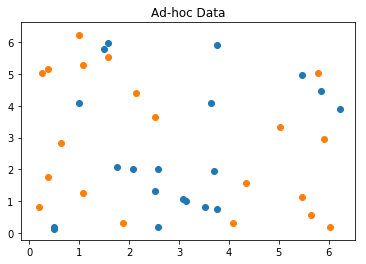

{'A': 0, 'B': 1}


In [35]:
feature_dim=2 # we support feature_dim 2 or 3
sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    gap=0.005, 
    PLOT_DATA=True
)
extra_test_data = sample_ad_hoc_data(sample_Total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

In [28]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
feature_map = FirstOrderExpansion(feature_dimension=feature_dim, depth=2)

qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
# backend = IBMQ.get_backend('ibmq_qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

"""declarative approach
params = {
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM'
    },
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}
algo_input = ClassificationInput(training_input, test_input, datapoints[0])
result = run_algorithm(params, algo_input)
"""

print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

testing success ratio: 0.65
preduction of datapoints:
ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B']


kernel matrix during the training:


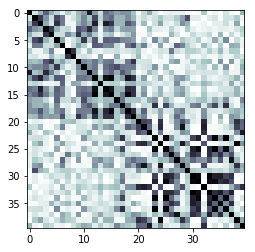

In [5]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

### The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

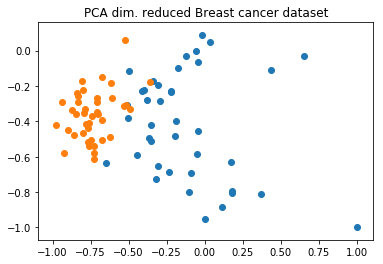

In [84]:
sample_Total, training_input, test_input, class_labels = Breast_cancer(
    training_size=40,
    test_size=80,
    n=4,
    PLOT_DATA=True
)

In [88]:
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

seed = 10598

feature_dim = 4

first_layer_feature_maps = {
     'secondOrderExpansion_depth_2': SecondOrderExpansion(feature_dimension=feature_dim, depth=1, entanglement='full'),
    # 'firstOrderExpansion_depth_2': FirstOrderExpansion(feature_dimension=feature_dim, depth=1),
    # 'firstOrderExpansion_depth_1': FirstOrderExpansion(feature_dimension=feature_dim, depth=1),
    # 'firstOrderExpansion_depth_3': FirstOrderExpansion(feature_dimension=feature_dim, depth=3)
    'pauli_z_expansion_depth_2': PauliZExpansion(feature_dimension=feature_dim, depth=1, entanglement='full'),
    'pauli_expansion_depth_2': PauliExpansion(feature_dimension=feature_dim, depth=1, entanglement='fullq'),
}

first_layer_models = {}

backend = BasicAer.get_backend('qasm_simulator')
#. backend = IBMQ.get_backend('ibmq_qasm_simulator')

quantum_instance = QuantumInstance(backend, shots=100, seed=seed, seed_transpiler=seed)

training_input_datapoints, training_class_to_label_map = split_dataset_to_data_and_labels(training_input)
X_train, y_train = training_input_datapoints
testing_input_datapoints, testing_class_to_label_map = split_dataset_to_data_and_labels(test_input)
X_test, y_test = testing_input_datapoints


X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
test_input['A'] = X_test[y_test == 0]
test_input['B'] = X_test[y_test == 1]

validation_input = {'A': X_valid[y_valid == 0], 'B': X_valid[y_valid == 1]}

class_level_preds_train = {'A': [], 'B': []}
class_level_preds_test = {'A': [], 'B': []}

def random_sample(X, frac=0.5):
    idx = np.random.randint(X.shape[0], size=int(X.shape[0] * frac))
    return X[idx, :]

print('now training first layer QSVMs')
for feature_map_name, feature_map in first_layer_feature_maps.items():
    print('training first layer QSVM for feature map ', feature_map_name)
    training_input_sampled = {}
    
    for class_name, data in training_input.items():
        training_input_sampled[class_name] = random_sample(data)
        print('size post sampling = ', training_input_sampled[class_name].shape)
        
    qsvm = QSVM(feature_map, training_input_sampled, test_input)
    # qsvm = SVM_Classical(training_input_sampled)
    
    result = qsvm.run(quantum_instance)
    print('train complete')
    
    train_preds = qsvm.predict(X_train)
    test_preds = qsvm.predict(X_test)
    valid_preds = qsvm.predict(X_valid)
    
    print('accuracy on training = ', accuracy_score(y_train, train_preds))
    print('accuracy on validation = ', accuracy_score(y_valid, valid_preds))
    print('accuracy on testing = ', accuracy_score(y_test, test_preds))
    
    for class_name, data in validation_input.items():
        preds = qsvm.predict(data)
        class_level_preds_train[class_name].append(np.expand_dims(preds, axis=1))
    
    for class_name, data in test_input.items():
        preds = qsvm.predict(data)
        class_level_preds_test[class_name].append(np.expand_dims(preds, axis=1))
    

for class_name, preds in class_level_preds_train.items():
    class_level_preds_train[class_name] = np.concatenate(preds, axis=1)

for class_name, preds in class_level_preds_test.items():
    class_level_preds_test[class_name] = np.concatenate(preds, axis=1)



print('training second level qsvm')
# qsvm = QSVM(SecondOrderExpansion(feature_dimension=3, depth=2, entanglement='linear'), 
#             class_level_preds_train, class_level_preds_test)
# result = qsvm.run(quantum_instance)
X_temp = class_level_preds_train['A']
X_temp2 = class_level_preds_train['B']
X_temp3 = np.concatenate([X_temp, X_temp2])
y_temp3 = np.concatenate([ np.array([0] * class_level_preds_train['A'].shape[0]) , np.array([1] * class_level_preds_train['B'].shape[0]) ])

X_t = class_level_preds_test['A']
X_t2 = class_level_preds_test['B']
X_t3 = np.concatenate([X_t, X_t2])
y_t3 = np.concatenate([ np.array([0] * class_level_preds_test['A'].shape[0]) , np.array([1] * class_level_preds_test['B'].shape[0]) ])

from sklearn.svm import SVC
clf = SVC()
clf.fit(X_temp3, y_temp3) 
# print('accuracy on training = ', accuracy_score(y_train_train, clf.predict(X_train_train)))
# print('accuracy on validation = ', accuracy_score(y_train_valid, clf.predict(X_train_valid)))
print('accuracy on testing = ', accuracy_score(y_t3, clf.predict(X_t3)))


print('train complete')
# print(result['testing_accuracy'])
# train_preds = qsvm.predict(X_train)
# test_preds = qsvm.predict(X_test)
# print('accuracy on training = ', accuracy_score(y_train, train_preds))
# print('accuracy on validation = ', accuracy_score(y_train_valid, clf.predict(X_train_valid)))
# print('accuracy on testing = ', accuracy_score(y_test, test_preds))



Due to the limited entangler_map, IZIZ is skipped.
Due to the limited entangler_map, ZIIZ is skipped.
Due to the limited entangler_map, ZIZI is skipped.
Due to the limited entangler_map, IZIZ is skipped.
Due to the limited entangler_map, ZIIZ is skipped.
Due to the limited entangler_map, ZIZI is skipped.


now training first layer QSVMs
training first layer QSVM for feature map  secondOrderExpansion_depth_2
size post sampling =  (20, 4)
size post sampling =  (20, 4)
train complete
accuracy on training =  0.8625
accuracy on validation =  0.8333333333333334
accuracy on testing =  0.8611111111111112
training first layer QSVM for feature map  pauli_z_expansion_depth_2
size post sampling =  (20, 4)
size post sampling =  (20, 4)
train complete
accuracy on training =  0.9
accuracy on validation =  0.8055555555555556
accuracy on testing =  0.7777777777777778
training first layer QSVM for feature map  pauli_expansion_depth_2
size post sampling =  (20, 4)
size post sampling =  (20, 4)
train complete
accuracy on training =  0.85
accuracy on validation =  0.75
accuracy on testing =  0.75
training second level qsvm
accuracy on testing =  0.8611111111111112
train complete


/Users/nikaashpuri/Documents/adobe/virtual-envs-python/python3-venv/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [87]:
help(SecondOrderExpansion)

Help on class SecondOrderExpansion in module qiskit.aqua.components.feature_maps.second_order_expansion:

class SecondOrderExpansion(qiskit.aqua.components.feature_maps.pauli_z_expansion.PauliZExpansion)
 |  SecondOrderExpansion(feature_dimension, depth=2, entangler_map=None, entanglement='full', data_map_func=<function self_product at 0x13494ba60>)
 |  
 |  Mapping data with the second order expansion followed by entangling gates.
 |  
 |  Refer to https://arxiv.org/pdf/1804.11326.pdf for details.
 |  
 |  Method resolution order:
 |      SecondOrderExpansion
 |      qiskit.aqua.components.feature_maps.pauli_z_expansion.PauliZExpansion
 |      qiskit.aqua.components.feature_maps.pauli_expansion.PauliExpansion
 |      qiskit.aqua.components.feature_maps.feature_map.FeatureMap
 |      qiskit.aqua.pluggable.Pluggable
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, feature_dimension, depth=2, entangler_map=None, entanglement='full', data_map_

In [91]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, load_iris, load_digits, load_wine, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# X, y = load_wine(return_X_y=True)
X, y = make_classification(n_samples=30000, n_features=30, n_classes=2, flip_y=0.08, class_sep=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)



kernels_first_layer = {'linear': 'linear', 
           # 'poly': 'poly', 
           'rbf': 'rbf', 
           # 'sigmoid': 'sigmoid'
          }

kernels_second_layer = {'linear': 'linear', 
           # 'poly': 'poly', 
           'rbf': 'rbf', 
           # 'sigmoid': 'sigmoid'
          }


C_values = [0.2, 0.4, 0.6]
gamma_values = [0.001, 0.01]

second_level_train = []
second_level_test = []

for kernel_name, kernel in kernels_first_layer.items():
    print('---------------------------')
    print('kernel = ', kernel_name)
    for c in C_values:
        print('c value = ', c)
        for gamma in gamma_values:
            print('gamma = ', gamma)
            clf = SVC(C=c, kernel=kernel, probability=True, gamma=gamma)
            # let's fit on a random sample of the data 
            idx = np.random.randint(X_train_train.shape[0], size=int(X_train_train.shape[0]/12) )
            clf.fit(X_train_train[idx,:], y_train_train[idx]) 
            print('accuracy on training = ', accuracy_score(y_train_train, clf.predict(X_train_train)))
            print('accuracy on validation = ', accuracy_score(y_train_valid, clf.predict(X_train_valid)))
            print('accuracy on testing = ', accuracy_score(y_test, clf.predict(X_test)))
            second_level_train.append(np.expand_dims(clf.predict(X_train_valid), axis=1))
            second_level_test.append(np.expand_dims(clf.predict(X_test), axis=1))
            # print('auc on training = ', roc_auc_score(y_train, clf.predict_proba(X_train)[ : ,1]))
            # print('auc on testing = ', roc_auc_score(y_test, clf.predict_proba(X_test)[ : ,1]))

x_train_second_level = np.concatenate(second_level_train, axis=1)
x_test_second_level = np.concatenate(second_level_test, axis=1)

print('training second level models')
print('data shape = ', x_train_second_level.shape)
for kernel_name, kernel in kernels_second_layer.items():
    print('kernel = ', kernel_name)
    for c in C_values:
        print('c value = ', c)
        for gamma in gamma_values:
            print('gamma = ', gamma)
            clf = SVC(C=c, kernel=kernel, probability=True, gamma=gamma)
            clf.fit(x_train_second_level, y_train_valid) 
            print('accuracy on training = ', accuracy_score(y_train_valid, clf.predict(x_train_second_level)))
            print('accuracy on testing = ', accuracy_score(y_test, clf.predict(x_test_second_level)))



---------------------------
kernel =  linear
c value =  0.2
gamma =  0.001
accuracy on training =  0.5693175911487339
accuracy on validation =  0.5590230664857531
accuracy on testing =  0.57
gamma =  0.01
accuracy on training =  0.5831291304670676
accuracy on validation =  0.5864616312377506
accuracy on testing =  0.5835353535353536
c value =  0.4
gamma =  0.001
accuracy on training =  0.5696888690873988
accuracy on validation =  0.574400723654455
accuracy on testing =  0.5656565656565656
gamma =  0.01
accuracy on training =  0.5990198262419247
accuracy on validation =  0.5967134026835519
accuracy on testing =  0.5964646464646465
c value =  0.6
gamma =  0.001
accuracy on training =  0.5676097126308755
accuracy on validation =  0.566711895070104
accuracy on testing =  0.5753535353535354
gamma =  0.01
accuracy on training =  0.6033266503304374
accuracy on validation =  0.6006331976481231
accuracy on testing =  0.6048484848484849
---------------------------
kernel =  rbf
c value =  0.2
ga